# Лабораторная работа 4. Поиск похожих изображений

### Работу выполнил:<span style="color:lightblue"> Бояринцев Дмитрий</span>

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/Ehvxe8lUDRBHs65SN0DjkekBFaiDh5VTile1HKnYSUwlNg)

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### 1. SIFT

In [5]:
img = cv2.imread('lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
img = cv2.drawKeypoints(gray,kp, img)

<img src="sift_keypoints.jpg" alt="drawing" width="300"/>

Про матчеры можно познакомиться подробнее в <a href="https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html">статье</a>.

724
[149.7698211669922, 151.03311157226562, 151.482666015625, 161.52398681640625, 162.9539794921875, 165.39952087402344, 173.7152862548828, 174.0804443359375, 176.5870819091797, 177.78919982910156]


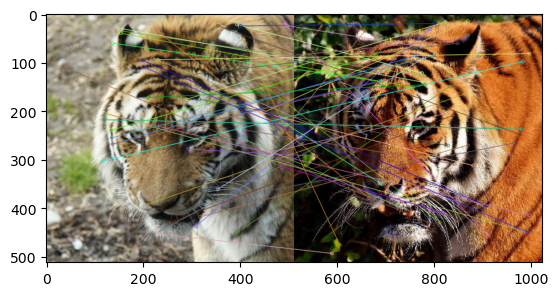

In [6]:
A = cv2.imread("images/0.jpg")
grayA= cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
B = cv2.imread("images/22.jpg")
grayB= cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kpA, desA = sift.detectAndCompute(grayA, None)
sift = cv2.SIFT_create()
kpB, desB = sift.detectAndCompute(grayB, None)

# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# match descriptors of both images
matches = bf.match(desA, desB)

# sort matches by distance
matches = sorted(matches, key=lambda x:x.distance)
# draw first 50 matches
matched_img = cv2.drawMatches(A, kpA, B, kpB, matches[:50], None, flags=2)
plt.imshow(matched_img[:, :, ::-1])
print(len(matches))
print([x.distance for x in matches[:10]])

### 5. Задание

Напишите скрипт/программу/систему поиска в коллекции изображений (dataset) похожих на запросную картинку (задается пользователем).
<br>
Размеры всех изображений составляют 512х512 пикселей.
<br>
<div>
Реализуйте несколько способов поиска на основе:
<ol>
    <li>гистограммы цветов;</li>
    <li>гистограммы градиентов;</li>
    <li>SIFT</li>
</ol>
</div>
Для каждого способа продумайте способы оценивания сходства векторов изображений. Например, для SIFT можно использовать количество совпавших особых точек или, например, среднее расстояние между первыми десятью совпавшими парами.
<div>
    Данные - Content Based Image Retrieval (CBIR) <a href="https://www.kaggle.com/datasets/theaayushbajaj/cbir-dataset">dataset</a> 
</div>

Сделайте графический интерфейс, например, посредством библиотеки gradio (см. <a href="https://www.gradio.app/guides/quickstart">краткое руководство</a>, <a href="https://huggingface.co/docs/hub/spaces-sdks-gradio">пример</a> и ещё  <a href="https://dev.to/haoliyin/show-off-your-computer-vision-model-with-gradio-1k3o">пример</a>)

Примерный графический интерфейс
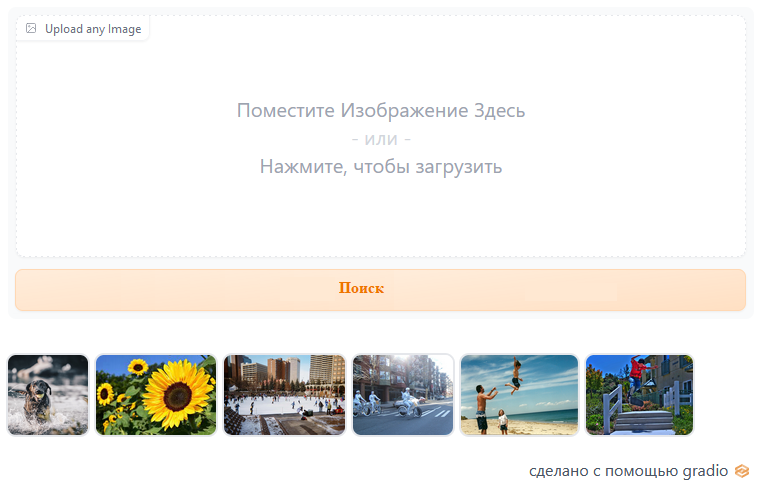

**(!) При разработке и тестировании кода работайте с 10-20 картинками из датасета, а потом уже запускайте работу со всей коллекцией изображений**

Примерные этапы, которые нужно реализовать:
1. Создание массива векторов признаков, описывающих содержание изображений (возможно стоит включить некоторую предобработку каждого изображения)
2. Предобработка и загрузка запросного изображения, для которой будет выполняться поиск похожих изображений
3. Вычисление вектора, описывающего содержание загруженного изображения
4. Сравнение вектора загруженого изображения с векторами из массива
5. Выбрать три наиболее подходящих изображения из коллекции по некоторой метрике сходства

**Сделайте выводы о наилучшем и наихудшем разработанном способе поиска похожих изображений.**

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity
import os
from typing import List, Tuple
import gradio as gr

class ImageSearcher:
    def __init__(self, dataset_path: str):
        self.dataset_path = dataset_path
        self.image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_features = {}
        self._extract_features()

    def _extract_features(self):
        """Извлечение признаков для всех изображений в датасете"""
        print("Извлечение признаков для изображений...")
        for img_file in self.image_files:
            img_path = os.path.join(self.dataset_path, img_file)
            image = cv2.imread(img_path)

            # Вычисление гистограммы цветов
            color_hist = self._calculate_color_histogram(image)

            # Вычисление гистограммы градиентов
            gradient_hist = self._calculate_gradient_histogram(image)

            # Вычисление SIFT признаков
            sift_features = self._calculate_sift_features(image)

            self.image_features[img_file] = {
                'color_hist': color_hist,
                'gradient_hist': gradient_hist,
                'sift_features': sift_features
            }
        print("Готово!")

    def _calculate_color_histogram(self, image):
        """Вычисление гистограммы цветов (BGR)"""
        # Вычисляем гистограмму для каждого канала
        hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
        hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])

        # Нормализуем гистограммы
        hist_b = cv2.normalize(hist_b, hist_b).flatten()
        hist_g = cv2.normalize(hist_g, hist_g).flatten()
        hist_r = cv2.normalize(hist_r, hist_r).flatten()

        # Объединяем гистограммы
        return np.concatenate([hist_b, hist_g, hist_r])

    def _calculate_gradient_histogram(self, image):
        """Вычисление гистограммы градиентов (HOG)"""
        # Преобразуем в оттенки серого
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Вычисляем HOG признаки
        hog_features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            feature_vector=True
        )

        return hog_features

    def _calculate_sift_features(self, image):
        """Вычисление SIFT признаков"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Создаем SIFT детектор
        sift = cv2.SIFT_create()

        # Находим ключевые точки и дескрипторы
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        return {
            'keypoints': keypoints,
            'descriptors': descriptors
        }

    def search_by_color_histogram(self, query_image, top_k=5):
        """Поиск по гистограмме цветов"""
        query_hist = self._calculate_color_histogram(query_image)

        similarities = []
        for img_file, features in self.image_features.items():
            # Вычисляем косинусное сходство между гистограммами
            similarity = np.dot(query_hist, features['color_hist']) / (
                np.linalg.norm(query_hist) * np.linalg.norm(features['color_hist'])
            )
            similarities.append((img_file, similarity))

        # Сортируем по убыванию сходства
        similarities.sort(key=lambda x: x[1], reverse=True)

        return similarities[:top_k]

    def search_by_gradient_histogram(self, query_image, top_k=5):
        """Поиск по гистограмме градиентов"""
        query_hist = self._calculate_gradient_histogram(query_image)

        similarities = []
        for img_file, features in self.image_features.items():
            # Вычисляем косинусное сходство между HOG признаками
            similarity = np.dot(query_hist, features['gradient_hist']) / (
                np.linalg.norm(query_hist) * np.linalg.norm(features['gradient_hist'])
            )
            similarities.append((img_file, similarity))

        # Сортируем по убыванию сходства
        similarities.sort(key=lambda x: x[1], reverse=True)

        return similarities[:top_k]

    def search_by_sift(self, query_image, top_k=5):
        """Поиск по SIFT признакам"""
        query_features = self._calculate_sift_features(query_image)

        if query_features['descriptors'] is None:
            return []  # Нет ключевых точек на запросном изображении

        similarities = []
        for img_file, features in self.image_features.items():
            if features['sift_features']['descriptors'] is None:
                continue  # Пропускаем изображения без ключевых точек

            # Сопоставляем дескрипторы
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(query_features['descriptors'], features['sift_features']['descriptors'], k=2)

            # Применяем тест Lowe для фильтрации хороших совпадений
            good_matches = []
            for match_pair in matches:
                if len(match_pair) == 2:
                    m, n = match_pair
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)

            # Количество хороших совпадений как мера сходства
            similarity = len(good_matches)
            similarities.append((img_file, similarity))

        # Сортируем по убыванию количества совпадений
        similarities.sort(key=lambda x: x[1], reverse=True)

        return similarities[:top_k]

# Создаем экземпляр поисковика
searcher = ImageSearcher('dataset/')

def search_images(query_image, method, top_k=5):
    """Функция для поиска изображений по запросу"""
    if query_image is None:
        return []

    # Изменяем размер изображения до 512x512, если нужно
    query_image_resized = cv2.resize(query_image, (512, 512))

    if method == 'Цветовая гистограмма':
        results = searcher.search_by_color_histogram(query_image_resized, top_k)
    elif method == 'Гистограмма градиентов':
        results = searcher.search_by_gradient_histogram(query_image_resized, top_k)
    elif method == 'SIFT':
        results = searcher.search_by_sift(query_image_resized, top_k)
    else:
        results = []

    # Подготавливаем результаты для отображения
    result_images = []
    for img_file, score in results:
        img_path = os.path.join('dataset/', img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Gradio ожидает RGB
        result_images.append(img)

    return result_images

# Создаем интерфейс Gradio
interface = gr.Interface(
    fn=search_images,
    inputs=[
        gr.Image(type="numpy", label="Запросное изображение"),
        gr.Radio(
            choices=["Цветовая гистограмма", "Гистограмма градиентов", "SIFT"],
            value="Цветовая гистограмма",
            label="Метод поиска"
        ),
        gr.Slider(1, 10, value=5, step=1, label="Количество результатов")
    ],
    outputs=gr.Gallery(label="Похожие изображения", columns=5, object_fit="scale-down", height="auto", allow_preview=False),
    title="Поиск похожих изображений",
    description="Загрузите изображение для поиска похожих в датасете, используя различные методы: гистограмму цветов, гистограмму градиентов или SIFT.",
    css="""
    .gallery-container {
        overflow-x: hidden !important;
    }
    .image-container {
        flex-shrink: 0;
    }
    #component-0 {
        overflow-x: hidden;
    }
    .gr-gallery {
        overflow-x: hidden;
    }
    .gr-image {
        object-fit: scale-down;
        max-width: 100%;
        max-height: 200px;
    }
    .grid-container {
        display: grid;
        grid-template-columns: repeat(5, 1fr);
        gap: 10px;
        overflow-x: hidden;
    }
    """,
    clear_btn="Очистить",
    submit_btn="Отправить",
)

if __name__ == "__main__":
    interface.launch()
